Script for 'building_heating' program in Python and SQL, licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

In the first part of the analysis, we construct a schematic representation of the building.

In [129]:
# The magic command "%matplotlib notebook" to make interactive plots within the Jupyter Notebook
# Import numpy library (for arrays operations)
# Import matplotlib.pyplot interface (for MATLAB-like plots)

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [130]:
# Range of coordinates indices x, y, z for the building plot

x, y, z = np.indices((12, 26, 6))

In [131]:
# Definition of the building volumes and colors

ground = (x < 12) & (y < 26) & (z < 1)
floors = (x < 12) & (y < 26) & (1 <= z) & (z < 6)
building = ground | floors
    
building_color = np.empty(building.shape, dtype=object)
building_color[ground] = 'grey'
building_color[floors] = 'white'

In [132]:
# Definition of the 4th floor apartments volumes and colors

apart_41 = (0 <= x) & (x < 12) & (19 <= y) & (y < 26) & (3 <= z) & (z < 4)
apart_42 = (8 <= x) & (x < 12) & (10 <= y) & (y < 19) & (3 <= z) & (z < 4)
apart_43 = (6 <= x) & (x < 12) & (0 <= y) & (y < 8) & (3 <= z) & (z < 4)
apart_44 = (0 <= x) & (x < 6) & (0 <= y) & (y < 10) & (3 <= z) & (z < 4)
apart_45 = (0 <= x) & (x < 6) & (10 <= y) & (y < 17) & (3 <= z) & (z < 4)
apartments = apart_41 | apart_42 | apart_43 | apart_44 | apart_45

apartments_color = np.empty(building.shape, dtype=object)
apartments_color[apart_41] = 'gold'
apartments_color[apart_42] = 'red'
apartments_color[apart_43] = 'blue'
apartments_color[apart_44] = 'violet'
apartments_color[apart_45] = 'green'

<IPython.core.display.Javascript object>


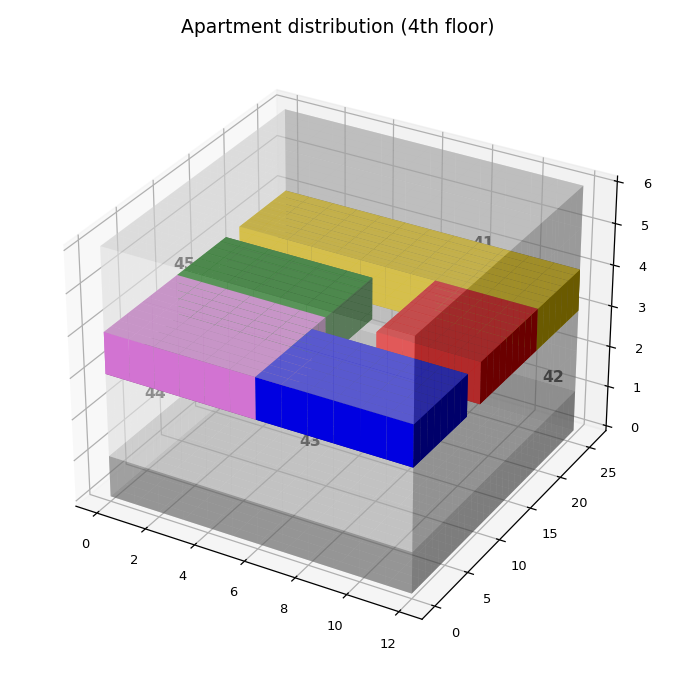

In [133]:
# Interactive 3D plot of the building

# Parameters, title and annotations of the 3D plot

house = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
house.voxels(building, facecolors=building_color, alpha=0.4)
house.voxels(apartments, facecolors=apartments_color)

plt.title('Apartment distribution (4th floor)')

house.text(8.5, -3, 3.3, '43', weight='bold')
house.text(2.5, -3, 3.3, '44', weight='bold')
house.text(7, 29, 3.3, '41', weight='bold')
house.text(13.5, 13.5, 3.3, '42', weight='bold')
house.text(-1.5, 14.5, 3.3, '45', weight='bold')

plt.tight_layout()

In the next part, we use Python librarires to set up a connection to the MySQL database containing the data of the building.

In [134]:
# Import os module (for interacting with the operating system)
# Import pandas library (for data analysis in Python)
# Import create_engine from the sqlalchemy toolkit (standard SQL toolkit in Python)
# Import load_dotenv from the dotenv module (for setting environment variables)

import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [135]:
# Load from a (hidden) .env file the MySQL credentials of the mysql database of the building

load_dotenv()
user = os.getenv('MySQL_USER')
passwd = os.getenv('MySQL_PASSWORD')
host = os.getenv('MySQL_HOST')
port = os.getenv('MySQL_PORT')
db = os.getenv('MySQL_DB')

In [136]:
# Create a connection ("engine") to the MySQL database using the credentials

engine = create_engine('mysql://%s:%s@%s:%s/%s' % (user, passwd, host, port, db))

The analysis involves 3 tables from the database, "Apartments", "Power" and "Temperatures", that we now describe.

The Apartments table contains the list of all units of the building (31 apartments + 4 weather stations). The "esmart_id" is the identification number given to each unit by the firm eSMART. The column "name" is a more intuitive identification number for the units. For instance, the name "43" corresponds to floor 4, apartment 3.

In [137]:
# Read the Apartments table into a DataFrame "df_apart"

df_apart = pd.read_sql('SELECT * FROM Apartments', engine)
df_apart.head()

,esmart_id,name
0,1046,11
1,1047,12
2,1048,13
3,1049,14
4,1050,15


For future use, we store in a DataFrame "df_dim" the names, the areas and the volumes of the 31 apartments of the building provided by the architect.

In [138]:
apartments = tuple(list(df_apart['name'])[:31])

areas = (127.1, 55.8, 78.1, 90.2, 46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 127.1, 55.8, 78.1, 90.2,
         46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 113.6, 69.3, 78.1, 90.2, 46.9, 82.5, 70.2, 120.6,
         85.5, 90.2, 46.9)

volumes = (330.46, 145.08, 203.06, 234.52, 121.94, 295.36, 180.18, 203.06, 234.52, 121.94, 330.46,
           145.08, 203.06, 234.52, 121.94, 295.36, 180.18, 203.06, 234.52, 121.94, 295.36, 180.18,
           203.06, 234.52, 121.94, 231, 203.58, 349.74, 247.95, 261.58, 136.01)

df_dim = pd.DataFrame({'apartment': apartments, 'area [m\u00b2]': areas, 'volume [m\u00b3]': volumes})
df_dim.head()

,apartment,area [m²],volume [m³]
0,11,127.1,330.46
1,12,55.8,145.08
2,13,78.1,203.06
3,14,90.2,234.52
4,15,46.9,121.94


The Power table contains data about power consumption for heating of each unit starting from 2017-10-12. Each row of the table contains the "apartment_id" (= esmart_id), the "module_id" of the module taking the measure, namely,

- <b>17</b> for electric power measured in Watt [W],
- <b>18</b> for the energy measured in Watt-hour [Wh]

the "date" of the measure and the "value" measured by the module.

In [139]:
# Read the first 100 rows of Power table into a DataFrame "df_P"

df_P = pd.read_sql('SELECT * FROM Power LIMIT 100', engine)
df_P.head()

,apartment_id,module_id,date,value
0,1026,17,2017-10-12,9242
1,1026,17,2017-10-13,10658
2,1026,17,2017-10-14,11523
3,1026,17,2017-10-15,12394
4,1026,17,2017-10-16,13260


The Temperatures table contains data about temperatures in [°C] of each apartment starting from 2021-03-15. Each row of the table contains the "apartment_id", the "module_id" for the room location of the module taking the measure, the "date" of the measure, the "action" of the module (<b>get</b> for temperature measured in the room and <b>set</b> for temperature set in the room) and the "value" of the temperature.

In [140]:
# Read the first 100 rows of Temperatures table into a DataFrame "df_T"

df_T = pd.read_sql('SELECT * FROM Temperatures LIMIT 100', engine)
df_T.head()

,apartment_id,module_id,date,action,value
0,1026,1,2021-03-15 11:46:46,set,22.0
1,1026,1,2021-03-15 11:56:56,set,22.0
2,1026,1,2021-03-15 12:07:06,set,22.0
3,1026,1,2021-03-15 12:17:17,set,22.0
4,1026,1,2021-03-15 12:27:27,set,22.0


In this part of the analysis, we retrieve and plot in pie chart and bar chart data about energy consumption of each apartment of the building, over any prescribed period of time between "start_date" and "end_date".

In [141]:
# Set start_date and end_date for the DataFrame of energy consumption

start_date = '"2022-02-07"'
end_date = '"2022-04-20"'

# Read, for each apartment of the building, the first energy after the start date into a DataFrame "df_start"

df_start = pd.read_sql('SELECT Apartments.name AS apartment, Power.date AS \'start date\', \
                   Power.value AS \'start energy [Wh]\' FROM Power INNER JOIN Apartments \
                   ON Power.apartment_id=Apartments.esmart_id WHERE Power.module_id=18 AND Power.date>=%s \
                   GROUP BY Apartments.name' % start_date, engine)

# Read, for each apartment of the building, the last energy before the end date into a DataFrame "df_end"

df_end = pd.read_sql('SELECT Apartments.name AS apartment, Power.date AS \'end date\', \
                   Power.value AS \'end energy [Wh]\' FROM Power INNER JOIN Apartments \
                   ON Power.apartment_id=Apartments.esmart_id WHERE Power.module_id=18 AND Power.date<=%s \
                   ORDER BY Power.date DESC LIMIT 31' % end_date, engine)

# Merge "df_start" and "df_end" into a DataFrame "df_E" (using "apartment" as key)
# (in 2018 there are missing measures; the first measure for apartment "O2" is at initial_date "2018-10-10")

df_E = pd.merge(df_start, df_end, how='left', on='apartment')

# Store in "df_E" the energy consumption and the energy consumption per cubic metre
# We divide the values by 1000 to get energies in [kW⋅h]

df_E['\u0394E [kWh]'] = [int((df_E['end energy [Wh]'][i]-df_E['start energy [Wh]'][i])/1000) for i in range(len(df_E))]
df_E['\u0394E per m\u00b3 [kWh/m\u00b3]'] = [round(df_E['\u0394E [kWh]'][i]/volumes[i], 1) for i in range(len(df_E))]

df_E.head()

,apartment,start date,start energy [Wh],end date,end energy [Wh],ΔE [kWh],ΔE per m³ [kWh/m³]
0,11,2022-02-07,10657000,2022-04-17 18:22:51,10770000,113,0.3
1,12,2022-02-07,9553000,2022-04-17 18:29:01,10022000,469,3.2
2,13,2022-02-07,11962000,2022-04-17 18:23:35,12520000,558,2.7
3,14,2022-02-07,12567000,2022-04-17 18:22:52,13451000,884,3.8
4,15,2022-02-07,11376000,2022-04-17 18:24:00,12099000,723,5.9


We use the data of "df_E" to produce a pie chart and a bar plot of the energy consumption for heating of each apartment of the building.

<IPython.core.display.Javascript object>


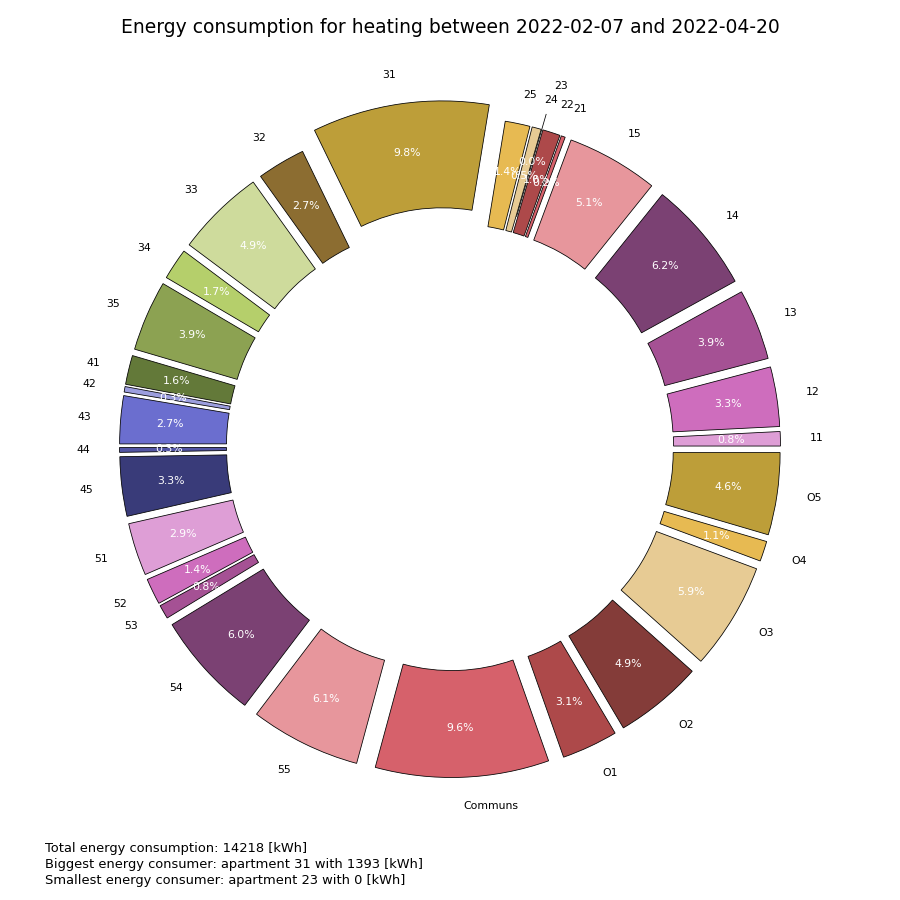

In [142]:
# Store in variable "data_E" the list of energy consumptions
# Store in variables "i_max" and "i_min" the indices of apartments having maximum and minimum energy consumptions

data_E = df_E['\u0394E [kWh]'].tolist()
i_max = data_E.index(max(data_E))
i_min = data_E.index(min(data_E))

# Check if there is energy consumption during the time period before proceeding with the plot

if max(data_E)>0:

    # Set in a "scales" the corresponding list the scales of the pie chart wedges
    # Set in a "wedges" dictionary the properties of the pie chart wedges
    # Set in a "colors" list the colors of the pie chart wedges
    # See https://matplotlib.org/stable/tutorials/colors/colormaps.html for details
    
    scales = [0.17 if i in {i_max, i_min} else 0.12 for i in range(len(data_E))]
    wedges = {'width':0.33, 'edgecolor':'k', 'lw':0.5}
    colors = plt.colormaps['tab20b_r'](range(20))

    # Parameters, title and legend of the pie chart plot

    _, EC = plt.subplots(figsize=(8, 8))
    _, _, pcts = EC.pie(data_E, labels=apartments, explode=scales, radius=0.9, autopct='%.1f%%',
                        colors=colors, wedgeprops=wedges, pctdistance=0.83, textprops={'size': 'x-small'})
    
    EC.set_title('Energy consumption for heating between %s and %s' % (eval(start_date), eval(end_date)))
    EC.text(0, 0, 'Total energy consumption: %s [kWh]' % sum(data_E), transform=EC.transAxes, size='small')
    EC.text(0, -0.02, 'Biggest energy consumer: apartment %s with %s [kWh]' \
            % (apartments[i_max], int(data_E[i_max])), transform=EC.transAxes, size='small')
    EC.text(0, -0.04, 'Smallest energy consumer: apartment %s with %s [kWh]' \
            % (apartments[i_min], int(data_E[i_min])), transform=EC.transAxes, size='small')
    plt.setp(pcts, color='w', size='x-small')

    plt.tight_layout()

else:
    print('Nothing to plot: no energy consumption between %s and %s' % (eval(start_date), eval(end_date)))

<IPython.core.display.Javascript object>


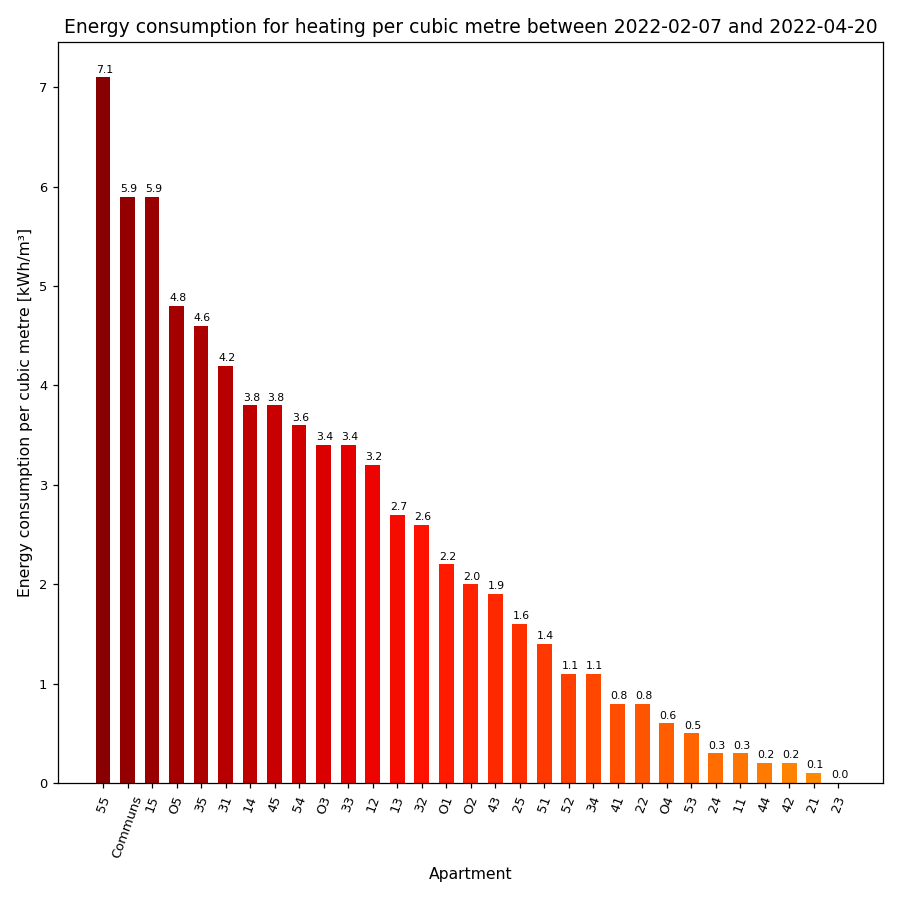

In [143]:
# Bar chart of energy consumption for heating per cubic metre for each apartment
# Check if there is energy consumption during the time period before proceeding with the plot

if max(data_E)>0:
    
    # Order the data by descending value of energy consumption per cubic metre
    # Store in variable "h" a small height defined in terms of df_E
    
    df_E = df_E.sort_values('\u0394E per m\u00b3 [kWh/m\u00b3]', ascending=False)
    h = max(df_E['\u0394E per m\u00b3 [kWh/m\u00b3]']) / 150

    # Parameters, title and annotations of the bar plot

    _, ECM = plt.subplots(figsize=(8, 8))
    ECM.set_title('Energy consumption for heating per cubic metre between %s and %s'
                 % (eval(start_date), eval(end_date)))
    
    colors = plt.colormaps['jet_r'](range(2,64,2))
    ECM.set_ylabel('Energy consumption per cubic metre [kWh/m\u00b3]')
    ECM.set_xlabel('Apartment')
    plt.xticks(rotation=70)
    
    fig = ECM.bar(df_E['apartment'], df_E['\u0394E per m\u00b3 [kWh/m\u00b3]'], color=colors, width=0.6)
    
    for bar in fig:
        plt.annotate(bar.get_height(), xy=(bar.get_x(), bar.get_height()+h), size='x-small')

    plt.rcParams['xtick.labelsize'] = 'small'
    plt.rcParams['ytick.labelsize'] = 'small'    
    plt.tight_layout()

else:
    print('Nothing to plot: no energy consumption between %s and %s' % (eval(start_date), eval(end_date)))

In this part of the analysis, we compare data about the temperatures measured and temperatures set in each apartment of the building, over the period of time between "start_date" and "end_date".

In [144]:
dflist_get, dflist_set = [], []

for apartment in apartments:
    
    # Store in "temp_get" the daily average temperature measured (get) between "start_date" and "end_date"
    # Done for each apartment of the building
    
    temp_get = pd.read_sql('SELECT DATE(Temperatures.date) AS date, \
                       ROUND(AVG(Temperatures.value),2) AS \'apart. %s (get)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="get" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (apartment, apartment, start_date, end_date), engine)
    
    # Store in "temp_set" the daily average temperature set (set) between "start_date" and "end_date"
    # Done for each apartment of the building
    
    temp_set = pd.read_sql('SELECT DATE(Temperatures.date) AS date, \
                       ROUND(AVG(Temperatures.value),2) AS \'apart. %s (set)\' \
                       FROM Temperatures INNER JOIN Apartments ON Temperatures.apartment_id=Apartments.esmart_id \
                       WHERE Apartments.name=\'%s\' AND Temperatures.action="set" \
                       AND Temperatures.date>=%s AND Temperatures.date<=%s \
                       AND TIME(Temperatures.date) BETWEEN "00:00:00" AND "23:59:59" \
                       GROUP BY DATE(Temperatures.date)' % (apartment, apartment, start_date, end_date), engine)
    
    # Collect the DataFrames "temp_get" and "temp_set" in the lists "dflist_get" and "dflist_set"
    
    dflist_get.append(temp_get)
    dflist_set.append(temp_set)

In [145]:
# Import the function "reduce" from library "functools" to merge lists of DataFrames

from functools import reduce

# Merge the DataFrames contained in "dflist_get" into a single DataFrame "merge_get"
# And make a copy of it in DataFrame "df_get"

merge_get = reduce(lambda x, y: pd.merge(x, y, on='date', how='outer'), dflist_get)
df_get = merge_get.copy(deep=True)

# Compute for each date the weighted average of the temperatures measured in each apartment
# The weights are the volumes of the apartments (the bigger the volume, the bigger the weight)
# See https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Mathematical_definition
# The missing values "NaN" are discarded by using a masked array (from the numpy.ma module)

masked_get = np.ma.masked_array(merge_get.drop('date', axis=1), np.isnan(merge_get.drop('date', axis=1)))
df_get['average (get)'] = np.ma.average(masked_get, axis=1, weights=volumes)

# Compute for each date the min and max temperatures measured in each apartment
# The original DataFrame "merge_get" is used for the computations
# Round to one decimal the data of the resulting DataFrame

df_get['min (get)'] = (merge_get.drop('date', axis=1)).min(axis=1)
df_get['max (get)'] = (merge_get.drop('date', axis=1)).max(axis=1)
df_get = round(df_get, 1)

# Merge the DataFrames contained in "dflist_set" into a single DataFrame "merge_set"
# And make a copy of it in DataFrame "df_set"

merge_set = reduce(lambda x, y: pd.merge(x, y, on='date', how='outer'), dflist_set)
df_set = merge_set.copy(deep=True)

# Compute for each date the usual average of the temperatures set in each apartment
# The missing values "NaN" are discarded by using a masked array (from the numpy.ma module)

masked_set = np.ma.masked_array(merge_set.drop('date', axis=1), np.isnan(merge_set.drop('date', axis=1)))
df_set['average (set)'] = np.ma.average(masked_set, axis=1)

# Compute for each date the min and max temperatures set in each apartment
# The original DataFrame "merge_set" is used for the computations
# Round to one decimal the data of the resulting DataFrame

df_set['min (set)'] = (merge_set.drop('date', axis=1)).min(axis=1)
df_set['max (set)'] = (merge_set.drop('date', axis=1)).max(axis=1)
df_set = round(df_set, 1)

df_set.head()

,date,apart. 11 (set),apart. 12 (set),apart. 13 (set),apart. 14 (set),apart. 15 (set),apart. 21 (set),apart. 22 (set),apart. 23 (set),apart. 24 (set),...,apart. 55 (set),apart. Communs (set),apart. O1 (set),apart. O2 (set),apart. O3 (set),apart. O4 (set),apart. O5 (set),average (set),min (set),max (set)
0,2022-02-07,19.6,21.0,21.7,22.5,25.0,19.8,23.5,19.5,20.3,...,21.5,20.2,20.2,23.8,21.0,21.0,24.0,21.2,18.5,25.0
1,2022-02-08,19.6,21.0,21.8,22.5,25.0,19.8,23.5,19.5,20.3,...,21.5,20.2,20.2,23.8,21.0,21.0,24.0,21.2,18.5,25.0
2,2022-02-09,19.6,21.0,21.8,22.5,25.0,19.8,23.5,19.5,20.3,...,21.5,20.2,20.2,23.8,21.0,21.0,24.0,21.1,18.5,25.0
3,2022-02-10,19.6,21.0,21.8,22.5,25.0,19.8,23.5,19.5,20.3,...,21.5,20.2,20.0,23.8,21.0,21.0,24.0,21.1,18.5,25.0
4,2022-02-11,19.6,21.0,21.8,22.5,25.0,19.8,23.5,19.5,20.3,...,21.5,20.2,20.2,23.8,21.0,21.0,24.0,21.1,18.5,25.0


<IPython.core.display.Javascript object>


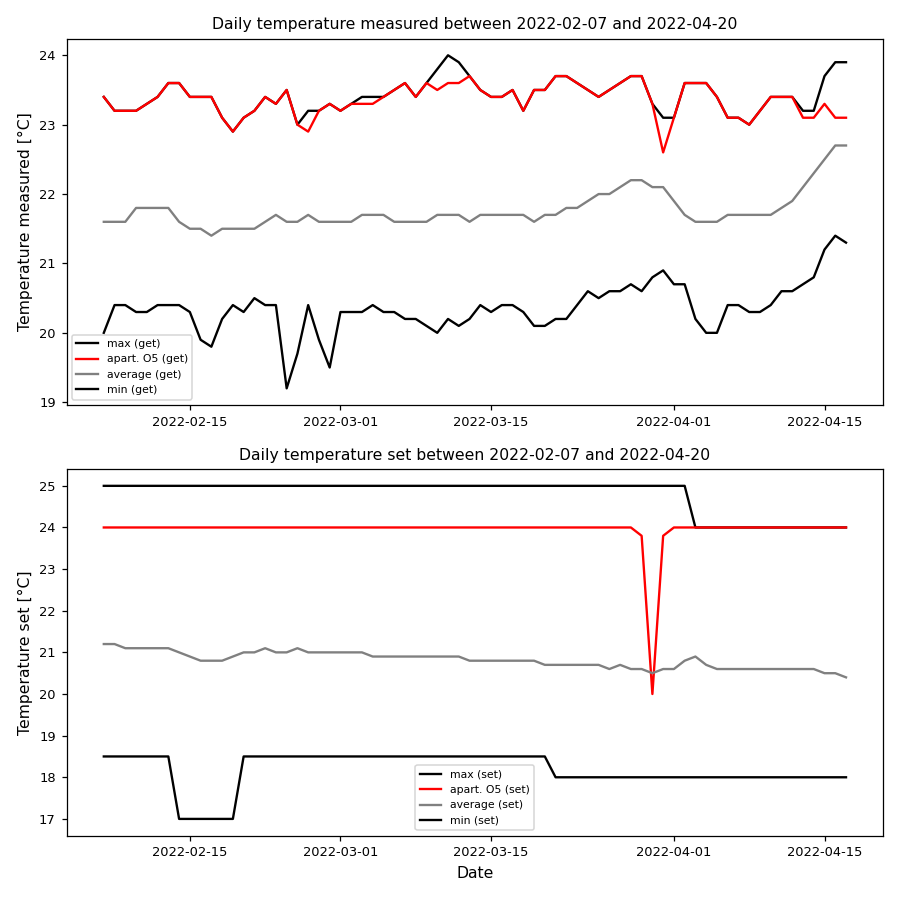

In [146]:
# Plot of the graphs of the temperatures measured and set for a given apartment
# In each figure, the min, max and average temperatures are also plotted

apartment = 'O5'

# Parameters, title, legends and annotations of the two graphs "g1"

_, (g1, g2) = plt.subplots(2, figsize=(8, 8))

g1.plot(df_get['date'], df_get['max (get)'], color='k', label='max (get)')
g1.plot(df_get['date'], df_get['apart. %s (get)'% apartment], color='r', label='apart. %s (get)' % apartment)
g1.plot(df_get['date'], df_get['average (get)'], color='grey', label='average (get)')
g1.plot(df_get['date'], df_get['min (get)'], color='k', label='min (get)')

g1.set_title('Daily temperature measured between %s and %s' % (eval(start_date), eval(end_date)), size='medium')
g1.legend(fontsize='x-small')
g1.set_ylabel('Temperature measured [°C]')

g2.plot(df_set['date'], df_set['max (set)'], color='k', label='max (set)')
g2.plot(df_set['date'], df_set['apart. %s (set)'% apartment], color='r', label='apart. %s (set)' % apartment)
g2.plot(df_set['date'], df_set['average (set)'], color='grey', label='average (set)')
g2.plot(df_set['date'], df_set['min (set)'], color='k', label='min (set)')

g2.set_title('Daily temperature set between %s and %s' % (eval(start_date), eval(end_date)), size='medium')
g2.legend(fontsize='x-small')
g2.set_ylabel('Temperature set [°C]')
g2.set_xlabel('Date')

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'

plt.tight_layout()

In [147]:
# Compute and store in a new DataFrame "df_md" the mean deviations
# of the measured temperature (get) and the set temperature (set) for each apartment

df_dev = pd.DataFrame()

# First, store in "df_dev" the deviations from the averages for each apartment

for x in apartments:
    df_dev['apart. %s deviation (get)'% x] = df_get['apart. %s (get)'% x] - df_get['average (get)']
    df_dev['apart. %s deviation (set)'% x] = df_set['apart. %s (set)'% x] - df_set['average (set)']

df_md = pd.DataFrame()
df_md['apartment'] = apartments

masked_get = np.ma.masked_array(df_dev.iloc[:, ::2], np.isnan(df_dev.iloc[:, ::2]))
df_md['md (get)'] = np.ma.average(masked_get, axis=0)

masked_set = np.ma.masked_array(df_dev.iloc[:, 1::2], np.isnan(df_dev.iloc[:, 1::2]))
df_md['md (set)'] = np.ma.average(masked_set, axis=0)

# We also store in df_mdthe product of the mean deviation (get) and the energy consumption per cubic metre
# The data of the resulting DataFrame is rounded to two decimals, and "apartment" is set as index column

df_md['md (set) ⋅ \u0394E/m\u00b3'] = df_md['md (set)'] * df_E['\u0394E per m\u00b3 [kWh/m\u00b3]']

df_md = round(df_md, 2)
blankIndex = [''] * len(df_md)
df_md.index = blankIndex

df_md.head()

,apartment,md (get),md (set),md (set) ⋅ ΔE/m³
,11,-0.11,-1.25,-0.38
,12,0.40,0.38,1.21
,13,0.42,0.42,1.13
,14,0.68,1.35,5.14
,15,0.47,3.57,21.04


<IPython.core.display.Javascript object>


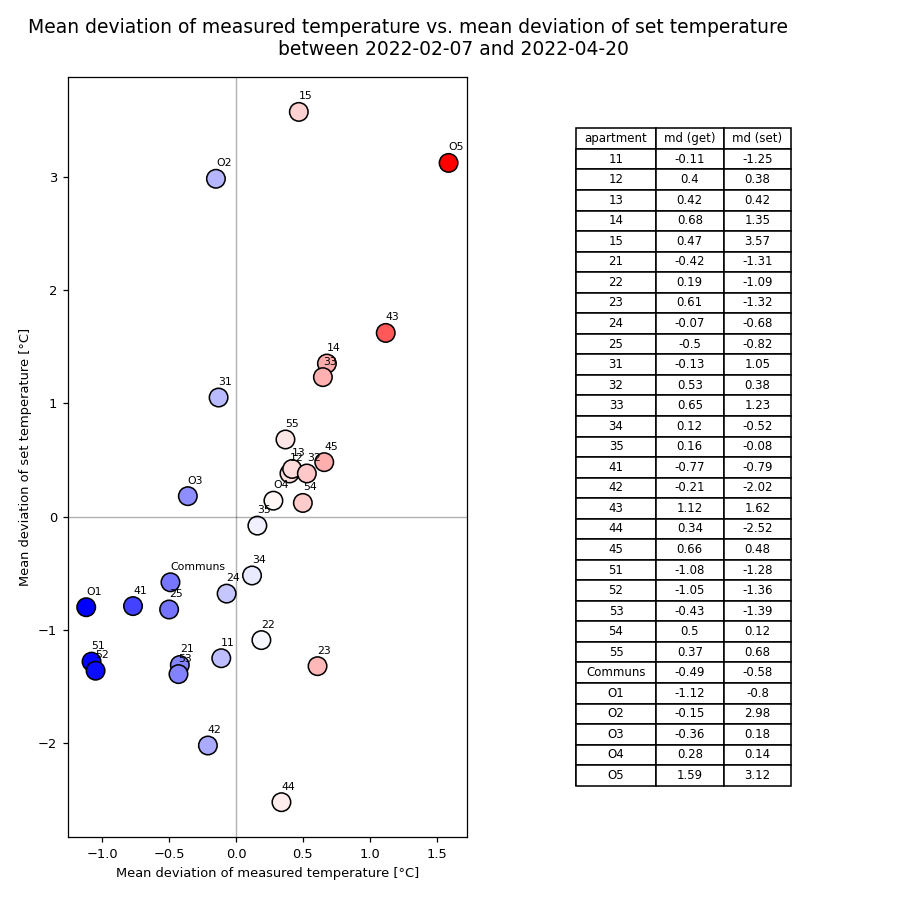

In [148]:
from pandas.plotting import table

_, (p1, p2) = plt.subplots(1,2, figsize=(8, 8))
plt.suptitle('Mean deviation of measured temperature vs. mean deviation of set temperature \
             \n between %s and %s' % (eval(start_date), eval(end_date)))

data_get = df_md['md (get)']
data_set = df_md['md (set)']
h_set = (max(data_set) - min(data_set)) / 55
values = [(data_get[i]-min(data_get))/(max(data_get) - min(data_get)) for i in range(len(data_get))]
colors = plt.colormaps['bwr'](values)

p1.scatter(data_get, data_set, s=140, c=colors, edgecolors='k')
p1.set_ylabel('Mean deviation of set temperature [°C]', size='small')
p1.set_xlabel('Mean deviation of measured temperature [°C]', size='small')
p1.axvline(color='k', lw=0.9, alpha=0.3)
p1.axhline(color='k', lw=0.9, alpha=0.3)

for apartment, x, y in zip(apartments, data_get, data_set):
    p1.text(x, y + h_set, apartment, size='x-small')

p2.axis('tight')
p2.axis('off')
the_table = table(p2, df_md[['apartment', 'md (get)', 'md (set)']],
                  loc='center', colWidths=[0.2, 0.17, 0.17], cellLoc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(7.5)

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'

plt.tight_layout()

<IPython.core.display.Javascript object>


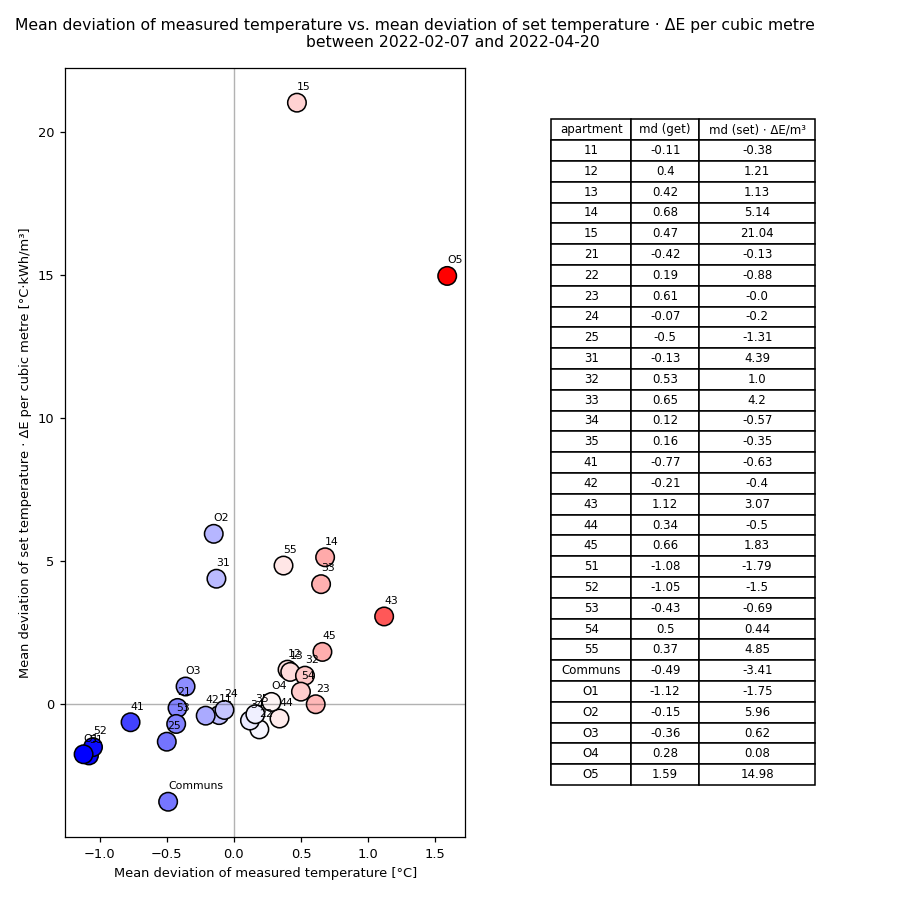

In [149]:
_, (p3, p4) = plt.subplots(1,2, figsize=(8, 8))
plt.suptitle('Mean deviation of measured temperature vs. mean deviation of set temperature ⋅ \u0394E per cubic metre \
             \n between %s and %s' % (eval(start_date), eval(end_date)), size=10)

data_set_E = df_md['md (set) ⋅ \u0394E/m\u00b3']
h_set_E = (max(data_set_E) - min(data_set_E)) / 55

p3.scatter(data_get, data_set_E, s=140, c=colors, edgecolors='k')
p3.set_ylabel('Mean deviation of set temperature ⋅ \u0394E per cubic metre [°C⋅kWh/m\u00b3]', size='small')
p3.set_xlabel('Mean deviation of measured temperature [°C]', size='small')
p3.axvline(color='k', lw=0.9, alpha=0.3)
p3.axhline(color='k', lw=0.9, alpha=0.3)

for apartment, x, y in zip(apartments, data_get, data_set_E):
    p3.text(x, y + h_set_E, apartment, size='x-small')

p4.axis('tight')
p4.axis('off')
the_table = table(p4, df_md[['apartment', 'md (get)', 'md (set) ⋅ \u0394E/m\u00b3']], loc='center',
                  colWidths=[0.2, 0.17, 0.29], cellLoc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(7.5)

plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.tight_layout()

<IPython.core.display.Javascript object>


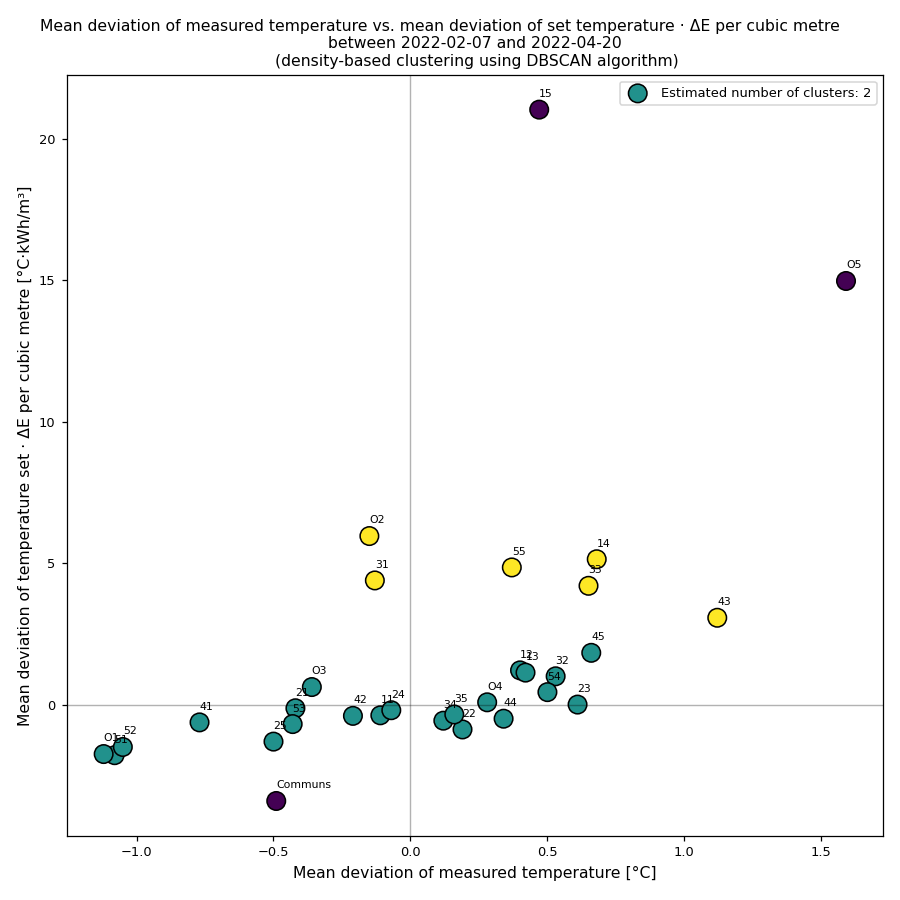

In [154]:
from sklearn.cluster import DBSCAN

# Reading in 2D Feature Space

data_cluster = df_md[['md (get)', 'md (set) ⋅ \u0394E/m\u00b3']].values

# Compute DBSCAN with "eps" parameter
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# And https://en.wikipedia.org/wiki/DBSCAN

model_cluster = DBSCAN(eps=1.3).fit(data_cluster)

# Scatter plot function
# Number of clusters in colors_fit, ignoring noise if present

colors_cluster = model_cluster.labels_
n_clusters = len(set(colors_cluster)) - (1 if -1 in colors_cluster else 0)

_, p5 = plt.subplots(figsize=(8, 8))
p5.set_title('Mean deviation of measured temperature vs. mean deviation of set temperature ⋅ \u0394E per cubic metre \
             \n between %s and %s \n (density-based clustering using DBSCAN algorithm)'
             % (eval(start_date), eval(end_date)), size=10)

p5.scatter(data_get, data_set_E, s=140, c=colors_cluster, edgecolors='k',
           label='Estimated number of clusters: %d' % n_clusters)

p5.set_ylabel('Mean deviation of temperature set ⋅ \u0394E per cubic metre [°C⋅kWh/m\u00b3]')
p5.set_xlabel('Mean deviation of measured temperature [°C]')
p5.axvline(color='k', lw=0.9, alpha=0.3)
p5.axhline(color='k', lw=0.9, alpha=0.3)
p5.legend(fontsize='small')

for apartment, x, y in zip(apartments, data_get, data_set_E):
    p5.text(x, y + h_set_E, apartment, size='x-small')

plt.tight_layout()